# Deep embedded clustering

## Library and module imports 

In [2]:
#standard libraries 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns

# Deep learning libraries
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.utils import Bunch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# import modules from utils 

import sys
import os

# Dynamically add the 'utils' folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../source/')))

# Now, you can import the functions
from utils.autoencoder import Autoencoder

## Importing Covariates dataframe

In [4]:
Covariates_df = pd.read_csv("../../data/cleaned_data/Covariates.csv")
Covariates_df.head()

,MunicipalityNumber,MunicipalityName,urban_typo,mountain_type,mountain_binary,Population,language,Canton,Yes [nbr],No [nbr],...,PES,Small right-wing parties,Municipal_rev [CHF],revenue_per_capita [CHF],elec_consumption_households_mwh_per_year_per_capita,elec_consumption_households_mwh_per_year,elec_consumption_mwh_per_year_per_capita,elec_consumption_mwh_per_year,mean_price (cts/kWh),std_price (cts/kWh)
0,1.0,Aeugst am Albis,Low-density peri-urban municipality (23),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,1998.0,german,Zürich,444.0,335.0,...,298.149915,75.687016,109921000.0,NaN,2.9119,5811,4.4623,8905,26.231762,2.464933
1,2.0,Affoltern am Albis,Urban municipality in a large agglomeration (11),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,12859.0,german,Zürich,1884.0,1260.0,...,1549.017114,191.375321,435719400.0,80080.757214,1.6492,21056,4.1840,53420,26.231762,2.464933
2,3.0,Bonstetten,Medium-density peri-urban municipality (22),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,5678.0,german,Zürich,1197.0,706.0,...,689.174556,77.173402,251102000.0,99960.987261,1.7356,9827,2.8006,15857,26.231762,2.464933
3,4.0,Hausen am Albis,Medium-density peri-urban municipality (22),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,3974.0,german,Zürich,764.0,555.0,...,628.072197,60.419112,165486900.0,100968.212325,2.3004,9128,3.9176,15545,26.231762,2.464933
4,5.0,Hedingen,Urban municipality in a large agglomeration (11),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,3963.0,german,Zürich,809.0,580.0,...,466.535182,82.008137,177331200.0,106826.024096,2.1157,8335,5.3155,20941,26.231762,2.464933


## Transforming dataframe

### Transforming categorical columns into integer columns

In [5]:
print("transforming dataframe...")
# Identify categorical columns
categorical_columns = Covariates_df.select_dtypes(include=['object', 'string']).columns
categorical_columns = categorical_columns.drop(["MunicipalityName", "Canton", "mountain_binary"])
print(categorical_columns)

# Apply encoding only to categorical columns
encoded_categorical = pd.get_dummies(Covariates_df[categorical_columns])
#print(encoded_categorical)

# Concatenate with untouched columns
non_categorical = Covariates_df.drop(columns=categorical_columns)
non_categorical = Covariates_df.drop(columns=["MunicipalityName", "MunicipalityNumber", "Canton", "mountain_binary"])
transformed_df = pd.concat([non_categorical, encoded_categorical.astype(int)], axis=1).drop(columns=categorical_columns)

print("Transformed DataFrame:")
print(transformed_df.dtypes) # Display the data types of each column
transformed_df[["elec_consumption_households_mwh_per_year", "elec_consumption_mwh_per_year"]]=transformed_df[["elec_consumption_households_mwh_per_year", "elec_consumption_mwh_per_year"]].astype(float)
print("data type of the modified elec columns:\n", transformed_df[["elec_consumption_households_mwh_per_year", "elec_consumption_mwh_per_year"]].dtypes)
transformed_df.to_csv("../../data/cleaned_data/numeric_covariates.csv")

transforming dataframe...
Index(['urban_typo', 'mountain_type', 'language'], dtype='object')
Transformed DataFrame:
Population                                                                float64
Yes [nbr]                                                                 float64
No [nbr]                                                                  float64
0-19 years                                                                float64
20-64 years                                                               float64
65 years or older                                                         float64
Private households                                                        float64
Housing and infrastructure area (%)                                       float64
Total employment                                                          float64
Primary sector                                                            float64
Secondary sector                                                

### relative percentages of political parties

In [6]:
transformed_political_df = transformed_df.copy()

political_columns = ["PLR", "PDC", "PS", "UDC", "PEV/PCS", "PVL", "PBD", "PST/Sol.", "Small right-wing parties"]
economic_sectors = ["Primary sector", "Secondary sector", "Tertiary sector"]
ages_columns = ["0-19 years", "20-64 years","65 years or older"]
votes_columns = ["Yes [nbr]", "No [nbr]"]

In [7]:
initial_political_sum = transformed_political_df[political_columns].sum(axis=1)
initial_economic_sector_sum = transformed_political_df[economic_sectors].sum(axis=1)
ages_sum = transformed_political_df[ages_columns].sum(axis=1)
votes_sum = transformed_political_df[votes_columns].sum(axis=1)

for col in political_columns:
    transformed_political_df[col]= transformed_political_df[col]/initial_political_sum

for col in economic_sectors:
    transformed_political_df[col]= transformed_political_df[col]/initial_economic_sector_sum
    
for col in ages_columns:
    transformed_political_df[col]= transformed_political_df[col]/ages_sum

for col in votes_columns:
    transformed_political_df[col]= transformed_political_df[col]/votes_sum


print(transformed_political_df[political_columns].sum(axis=1))
print(transformed_political_df[economic_sectors].sum(axis=1))
print(transformed_political_df[ages_columns].sum(axis=1))
print(transformed_political_df[votes_columns].sum(axis=1))

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2126    0.0
2127    0.0
2128    0.0
2129    1.0
2130    1.0
Length: 2131, dtype: float64
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2126    0.0
2127    0.0
2128    0.0
2129    1.0
2130    1.0
Length: 2131, dtype: float64
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2126    0.0
2127    0.0
2128    0.0
2129    1.0
2130    1.0
Length: 2131, dtype: float64
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2126    0.0
2127    0.0
2128    0.0
2129    0.0
2130    1.0
Length: 2131, dtype: float64


## Removing NANs and estimating missing values

In [8]:
# Verifying that Nan values have correctly been removed
print(transformed_political_df.isna().sum())  # Inspect the first few rows

print(transformed_political_df.isna().any(axis=1).sum())  # take a look at each row at once
correctable_columns = transformed_political_df.columns.drop(
    [
    "PLR", 
    "PDC", 
    "PS", 
    "UDC", 
    "PEV/PCS", 
    "PVL", 
    "PBD", 
    "PST/Sol.", 
    "PES", 
    "Small right-wing parties", 
    "Primary sector", 
    "Secondary sector", 
    "Tertiary sector", 
    ]
)
processed_transformed_df = transformed_political_df.copy()
for column in correctable_columns:
    processed_transformed_df[column] = processed_transformed_df[column].fillna(processed_transformed_df[column].mean())


processed_transformed_df = processed_transformed_df.apply(pd.to_numeric, errors='coerce').fillna(0) # in case their are NANs remaining
print(processed_transformed_df.isna().sum())  # Inspect the first few rows


Population                                                                   1
Yes [nbr]                                                                  268
No [nbr]                                                                   268
0-19 years                                                                 246
20-64 years                                                                246
65 years or older                                                          246
Private households                                                           1
Housing and infrastructure area (%)                                          1
Total employment                                                            88
Primary sector                                                             277
Secondary sector                                                           300
Tertiary sector                                                            251
New housing units built per 1000 inhabitants        

In [9]:
processed_transformed_df[political_columns].sample(5)

,PLR,PDC,PS,UDC,PEV/PCS,PVL,PBD,PST/Sol.,Small right-wing parties
588,0.000000,0.428571,0.166667,0.404762,0.000000,0.000000,0.000000,0.000000,0.000000
482,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2056,0.210111,0.075087,0.248211,0.175252,0.009110,0.069616,0.003118,0.139517,0.069978
1400,0.127705,0.168029,0.190821,0.379055,0.011476,0.076948,0.036895,0.000000,0.009071
1157,0.373007,0.049947,0.160468,0.213603,0.000000,0.075452,0.127524,0.000000,0.000000


## Scaling the dataframe

In [10]:
# Creating a copy of the dataframe
scaled_processed_transformed_df = processed_transformed_df.copy()

# Step 1: Identify continuous variables
# Let's assume continuous variables are of float type. You can adjust this based on your dataset.
continuous_columns = scaled_processed_transformed_df.select_dtypes(include=['float64']).columns

# Step 2: Scale only continuous variables
scaler = StandardScaler()

# Scale only the continuous columns
scaled_processed_transformed_df[continuous_columns] = scaler.fit_transform(scaled_processed_transformed_df[continuous_columns])
scaled_processed_transformed_df.to_csv("../../data/cleaned_data/calculable_covariates.csv")
scaled_processed_transformed_df.sample(5)

,Population,Yes [nbr],No [nbr],0-19 years,20-64 years,65 years or older,Private households,Housing and infrastructure area (%),Total employment,Primary sector,...,urban_typo_Urban municipality in a small or non-agglomerated area (13),mountain_type_Alpes (4),mountain_type_Forêt Noire - Jura Souabe (2),mountain_type_Jura (3),mountain_type_Moyen-pays - Rhin supérieur (1),mountain_type_pas de classification,language_french,language_german,language_italian,language_romansh
757,-0.269000,0.000000,5.033877e-16,0.000000,0.000000,-6.779984e-16,-0.247452,-0.139298,-0.157610,-0.853508,...,0,0,0,0,1,0,1,0,0,0
291,-0.019559,-0.392251,3.922510e-01,-0.565768,-0.808048,1.038215e+00,-0.006208,-0.122190,-0.046180,-0.429114,...,0,1,0,0,0,0,0,1,0,0
169,0.017576,0.546321,-5.463210e-01,-0.455784,0.609520,-1.029830e-01,0.031297,-0.090096,-0.059203,-0.179827,...,0,0,0,0,1,0,0,1,0,0
110,-0.005253,-0.075396,7.539630e-02,0.420948,-0.590151,1.153951e-01,-0.019146,-0.092410,-0.092786,-0.362618,...,0,0,0,0,1,0,0,1,0,0
1467,-0.017428,-0.874803,8.748031e-01,0.007986,0.718224,-5.414081e-01,-0.039291,-0.076278,-0.069373,-0.527933,...,0,0,0,0,1,0,0,1,0,0


## Checking for relationship types between covariates (non linear and linear)

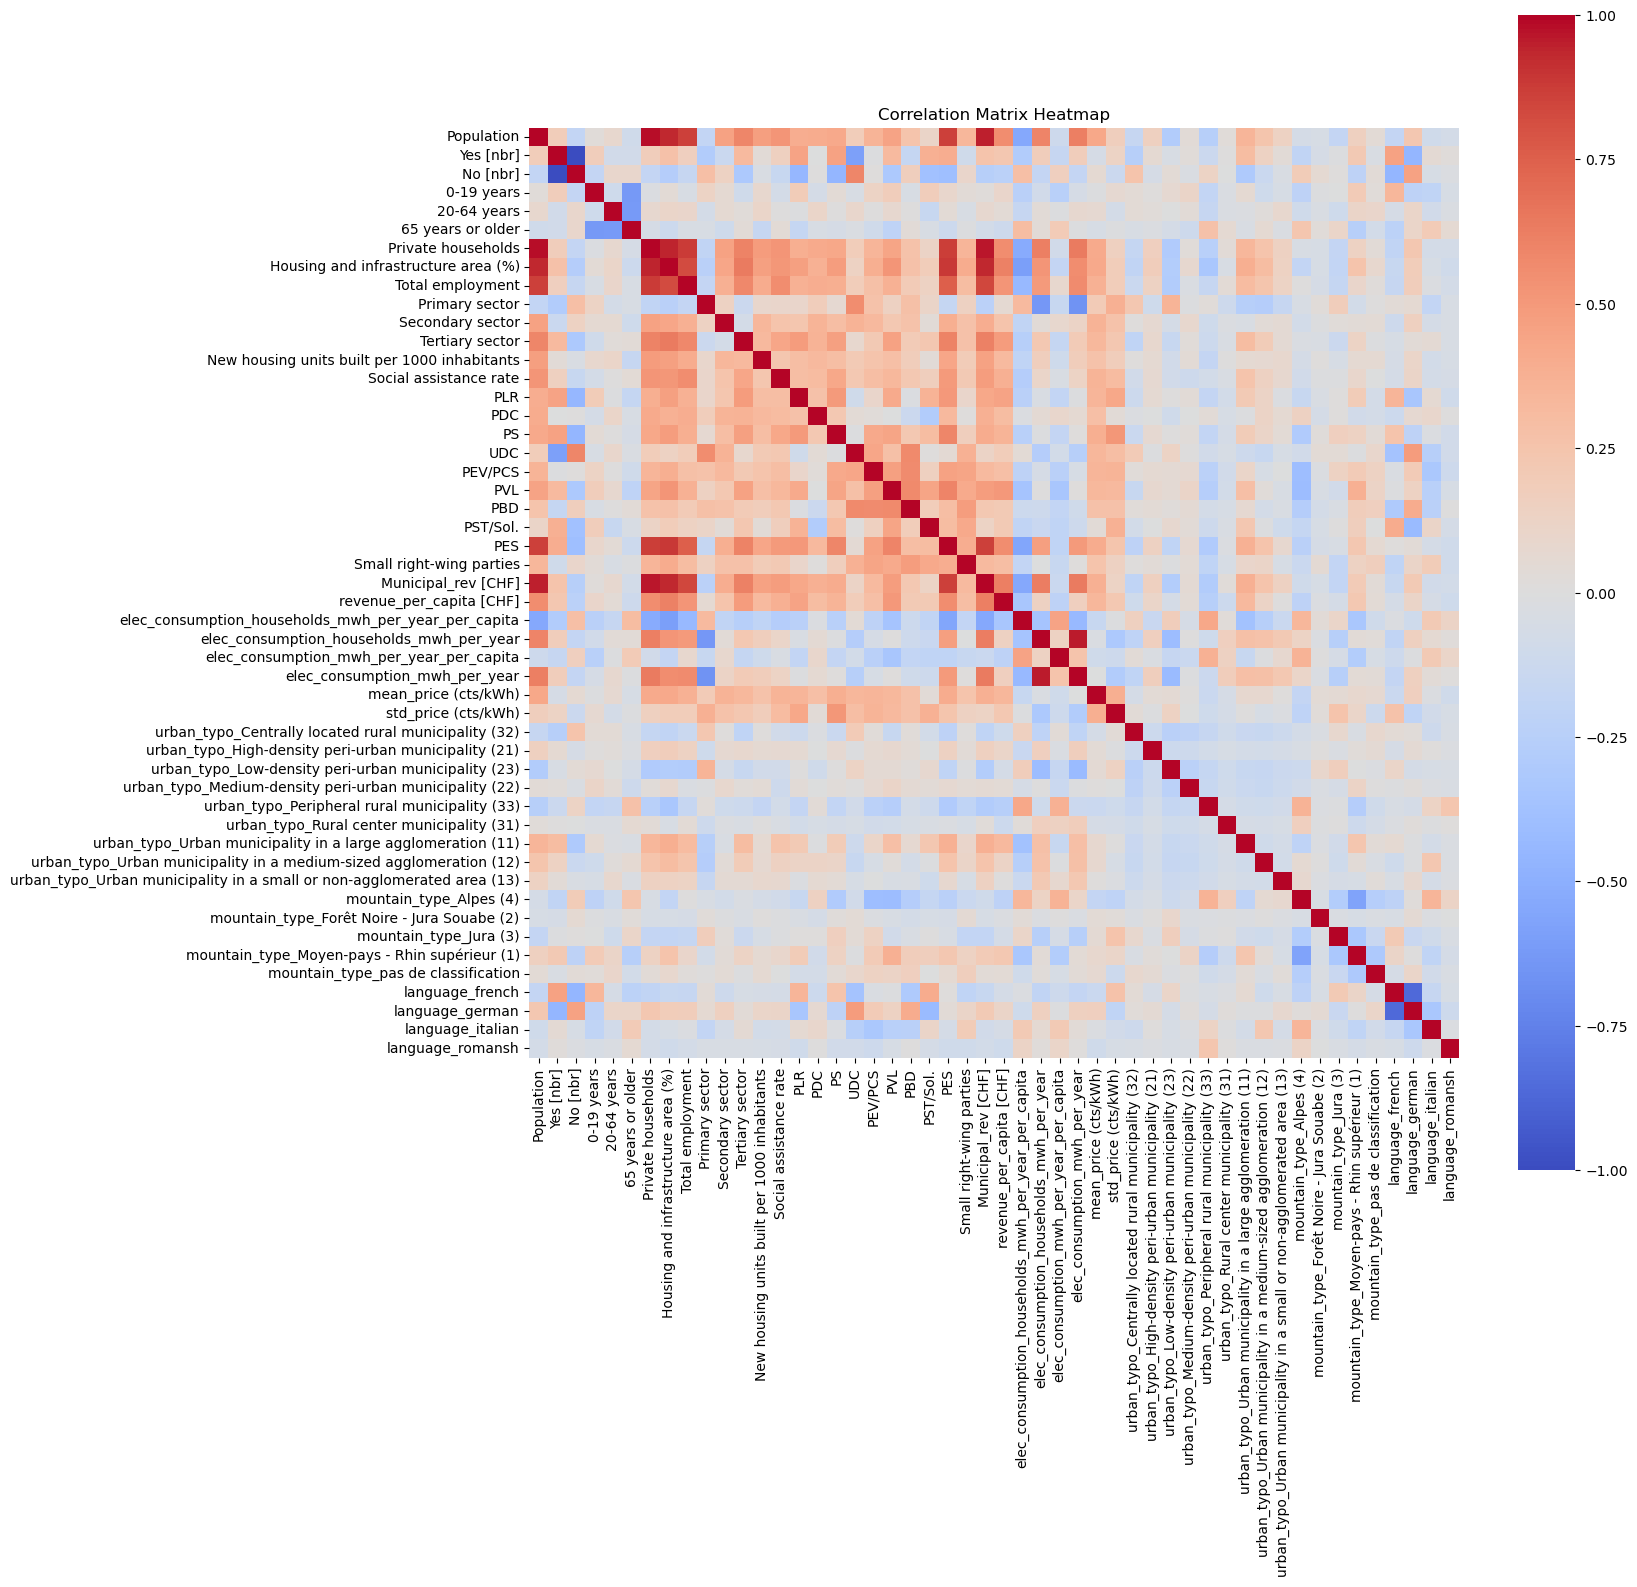

In [11]:
# Spearman's correlaiton coefficient 
correlation_matrix = scaled_processed_transformed_df.corr(method='spearman')

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(15, 15))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()


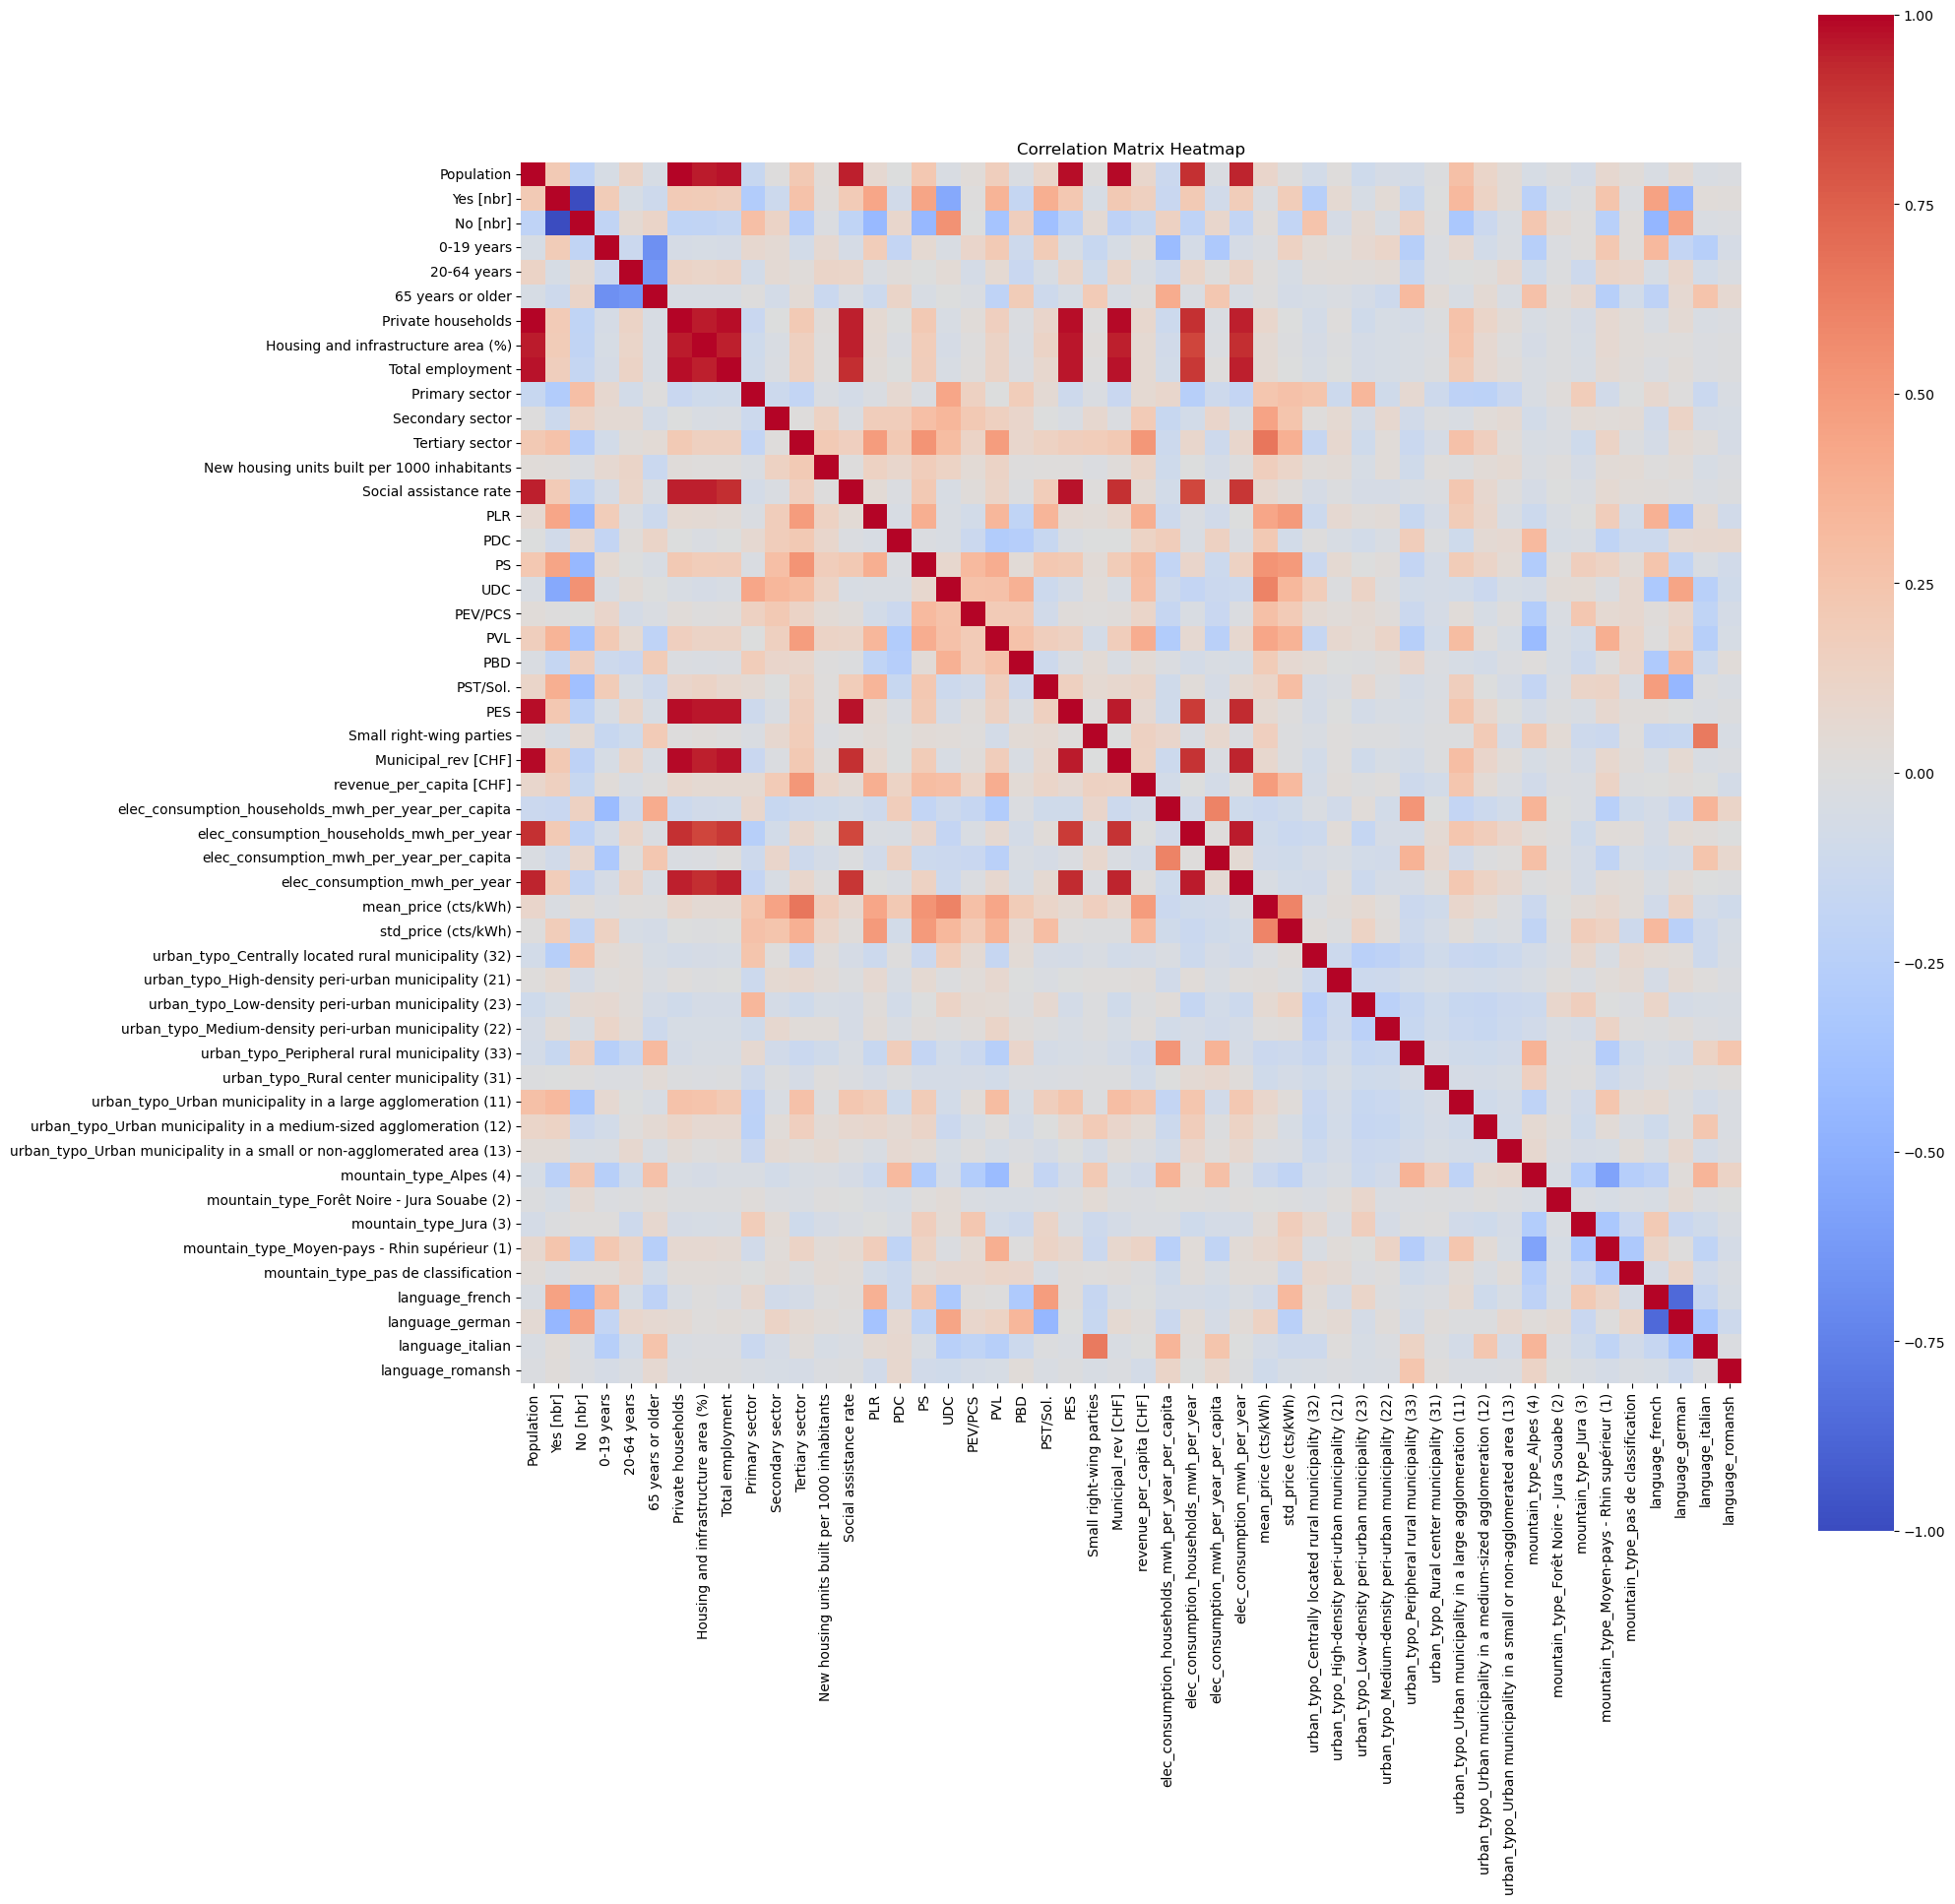

In [12]:
# Spearman's correlaiton coefficient 
correlation_matrix = scaled_processed_transformed_df.corr(method='pearson')

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(20, 20))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

The data seems to hold non linear relationships > which leads us to applying deep embedded clusteing coupled to DBSCAN rather than PCA Analysis with K-means clustering

## Model definition

### Defintion of a simple model

In [ ]:
# copying dataframe
df = scaled_processed_transformed_df.copy()

# Step 4: Define the Autoencoder Model using PyTorch
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder part
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dim)  # Latent space representation
        )
        
        # Decoder part
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()  # Output layer with sigmoid activation
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Returns the encoded (latent) representation of the input"""
        return self.encoder(x)

# Step 5: Prepare data for PyTorch (convert to tensors)
X_tensor = torch.tensor(df.values, dtype=torch.float32)

# Step 6: Instantiate the Autoencoder
input_dim = df.shape[1]
print(f"\nInput dim : {input_dim}\n")
encoding_dim = 3 # Latent space dimension (you can change this)
autoencoder = Autoencoder(input_dim, encoding_dim)

# Step 7: Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Step 8: Train the Autoencoder
epochs = 100
batch_size = 16
dataset = TensorDataset(X_tensor, X_tensor)  # Input and output are the same for autoencoder
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Running Neural network...")
for epoch in range(epochs):
    for data in dataloader:
        inputs, _ = data  # We don't need the output, as we are using the input itself
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Step 9: Get the Encoded (Latent) Features
X_encoded = autoencoder.encode(X_tensor).detach().numpy()

np.savetxt('../../data/cleaned_data/X_encoded_simple.csv', X_encoded, delimiter=',')

print("\nModel trained!")



Input dim : 51

Running Neural network...
Epoch [10/100], Loss: 0.9165
Epoch [20/100], Loss: 0.5776
Epoch [30/100], Loss: 1.0424
Epoch [40/100], Loss: 0.4901
Epoch [50/100], Loss: 0.4394
Epoch [60/100], Loss: 0.1949
Epoch [70/100], Loss: 0.4497
Epoch [80/100], Loss: 0.4767
Epoch [90/100], Loss: 0.6630
Epoch [100/100], Loss: 0.6708

Model trained!


### Defintion of a more complex model

In [13]:
# Assuming you have a DataFrame of covariates called df
df = scaled_processed_transformed_df.copy()

# Step 3: Define the Autoencoder Model using PyTorch
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder with Batch Normalization and Dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, encoding_dim)  # Latent space representation
        )
        
        # Decoder with Batch Normalization and Dropout
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(0.2),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, input_dim),
            nn.Sigmoid()  # Output layer with sigmoid activation
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Returns the encoded (latent) representation of the input"""
        return self.encoder(x)

# Step 4: Prepare data for PyTorch (convert to tensors)
X_tensor = torch.tensor(df.values, dtype=torch.float32)

# Step 5: Instantiate the Autoencoder
input_dim = df.shape[1]  # Number of features in the dataset
encoding_dim = 5  # Increased latent space dimension
autoencoder = Autoencoder(input_dim, encoding_dim)

# Step 6: Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Step 7: Train the Autoencoder
epochs = 100
batch_size = 16
dataset = TensorDataset(X_tensor, X_tensor)  # Input and output are the same for autoencoder
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Running Neural network...")
for epoch in range(epochs):
    for data in dataloader:
        inputs, _ = data  # We don't need the output, as we are using the input itself
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Step 8: Get the Encoded (Latent) Features
X_encoded = autoencoder.encode(X_tensor).detach().numpy()

# Save the array to a CSV file
np.savetxt('../../data/cleaned_data/X_encoded.csv', X_encoded, delimiter=',')

print("\nModel trained !")


Running Neural network...
Epoch [10/100], Loss: 0.3857
Epoch [20/100], Loss: 0.2881
Epoch [30/100], Loss: 0.3430
Epoch [40/100], Loss: 0.9208
Epoch [50/100], Loss: 0.3384
Epoch [60/100], Loss: 0.2104
Epoch [70/100], Loss: 0.4022
Epoch [80/100], Loss: 0.3842
Epoch [90/100], Loss: 0.3741
Epoch [100/100], Loss: 0.3366

Model trained !


## Analyzing latent space

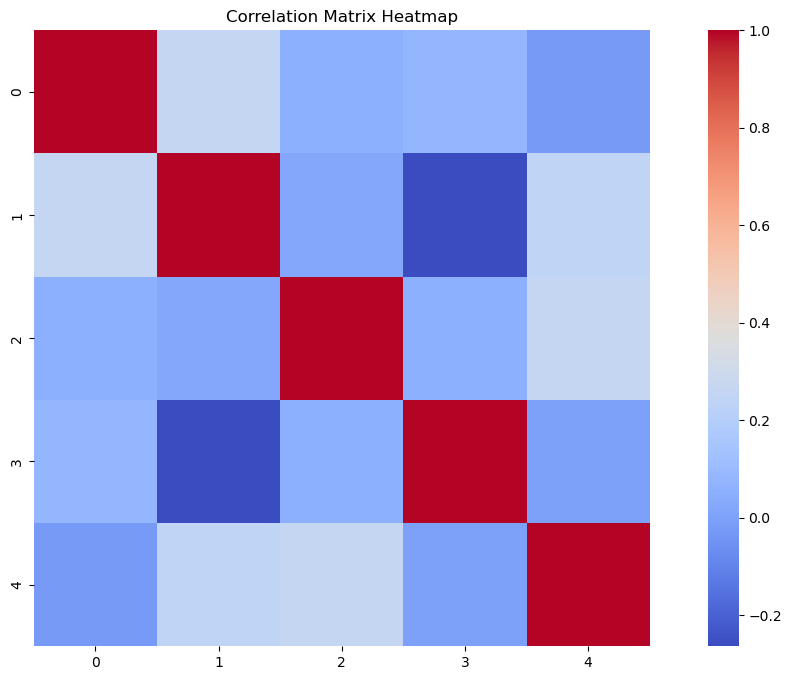

In [14]:
# Spearman's correlaiton coefficient 
correlation_matrix = np.corrcoef(X_encoded, rowvar=False)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(15, 8))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

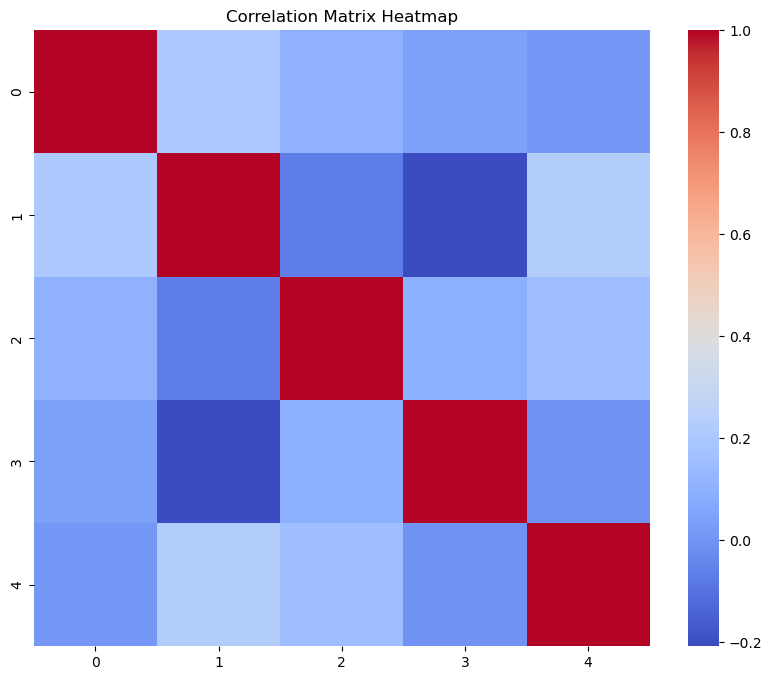

In [15]:
from scipy.stats import spearmanr

# Calculate the Spearman correlation matrix
corr, _ = spearmanr(X_encoded, axis=0)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))  # Set the size of the plot
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

## DBSCAN clustering

ep: 0.01
ms: 2
[-1]
ms: 3
[-1]
ms: 4
[-1]
ms: 5
[-1]
ms: 6
[-1]
ms: 7
[-1]
ms: 8
[-1]
ms: 9
[-1]
ms: 10
[-1]
ms: 11
[-1]
ms: 12
[-1]
ms: 13
[-1]
ms: 14
[-1]
ep: 0.09777777777777778
ms: 2
[-1  0  1  2  3  4  5  6  7  8  9 10 11]
ms: 3
[-1]
ms: 4
[-1]
ms: 5
[-1]
ms: 6
[-1]
ms: 7
[-1]
ms: 8
[-1]
ms: 9
[-1]
ms: 10
[-1]
ms: 11
[-1]
ms: 12
[-1]
ms: 13
[-1]
ms: 14
[-1]
ep: 0.18555555555555558
ms: 2
[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100]
ms: 3
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25]
ms: 4
[-1  0  1  2  3  4  5  6  7  8]
ms: 5
[-1  0  1  2]
ms: 6
[-1  0]
ms: 7
[-1  0]
ms: 8
[-1  0]


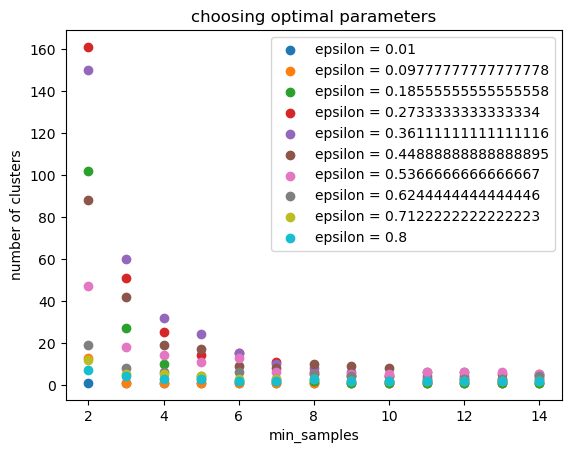

In [16]:
eps = np.linspace(0.01, 0.8, 10)
min_samples_array = np.arange(2, 15, 1)

for ep in eps:
    print("ep:", ep)
    clust_number_list = []
    for ms in min_samples_array:
        
        print("ms:", ms)
        # Step 9: Apply DBSCAN to the latent space
        dbscan_algo = DBSCAN(eps=ep, min_samples=ms)  # Adjust eps and min_samples as needed
        clusters = dbscan_algo.fit_predict(X_encoded)
        print(np.unique(clusters))
        clust_number_list.append(len(np.unique(clusters)))
    plt.scatter(min_samples_array, clust_number_list, label=f"epsilon = {ep}")
plt.xlabel("min_samples")
plt.ylabel("number of clusters")
plt.legend()
plt.title("choosing optimal parameters")
plt.show()

In [17]:

# Step 9: Apply DBSCAN to the latent space
dbscan = DBSCAN(eps=0.4, min_samples=14)  # Adjust eps and min_samples as needed
clusters = dbscan.fit_predict(X_encoded)

# Step 10: Optionally, you can visualize the clusters or perform further evaluation
print("Cluster labels:", clusters)

Cluster labels: [ 0 -1  0 ...  1 -1 -1]


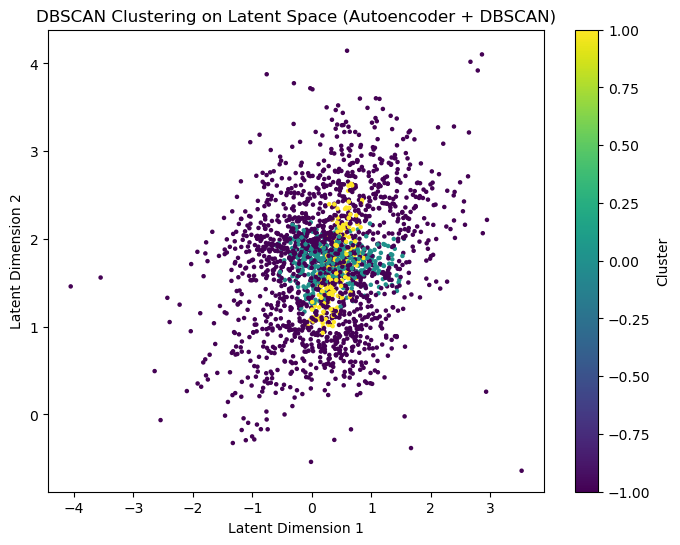

Silhouette Score: -0.04123060032725334
Davies-Bouldin Index: 2.999771869689937
Cluster labels: [ 0 -1  0 ...  1 -1 -1]


In [18]:
# Step 11: Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=clusters, cmap='viridis', s=5)
plt.title("DBSCAN Clustering on Latent Space (Autoencoder + DBSCAN)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.colorbar(label='Cluster')
plt.show()

# Step 12: Evaluate the clustering (optional)
silhouette_avg = silhouette_score(X_encoded, clusters)
print(f"Silhouette Score: {silhouette_avg}")

db_score = davies_bouldin_score(X_encoded, clusters)
print(f"Davies-Bouldin Index: {db_score}")

# Cluster and True Labels comparison (if you have labels)
print("Cluster labels:", clusters)

## K-Means Clustering

In [19]:
# Number of clusters to test
number_of_clusters = np.arange(2, 21)  # Clusters from 2 to 20

# Lists to store evaluation scores
silhouette_list = []
davies_bouldin_list = []
silhouette_max=0

for num_clusters in number_of_clusters: 
    # Step 9: Apply K-Means to the latent space
    kmeans = KMeans(n_clusters=num_clusters,  init='k-means++', n_init=10, random_state=42)
    clusters = kmeans.fit_predict(X_encoded)

    # Step 11: Evaluate clustering performance
    silhouette_avg = silhouette_score(X_encoded, clusters)
    silhouette_list.append(silhouette_avg)

    davies_bouldin = davies_bouldin_score(X_encoded, clusters)
    davies_bouldin_list.append(davies_bouldin)

    if silhouette_avg >= silhouette_max:
        silhouette_max = silhouette_avg
        kept_cluster_number = num_clusters
        best_clusters = clusters


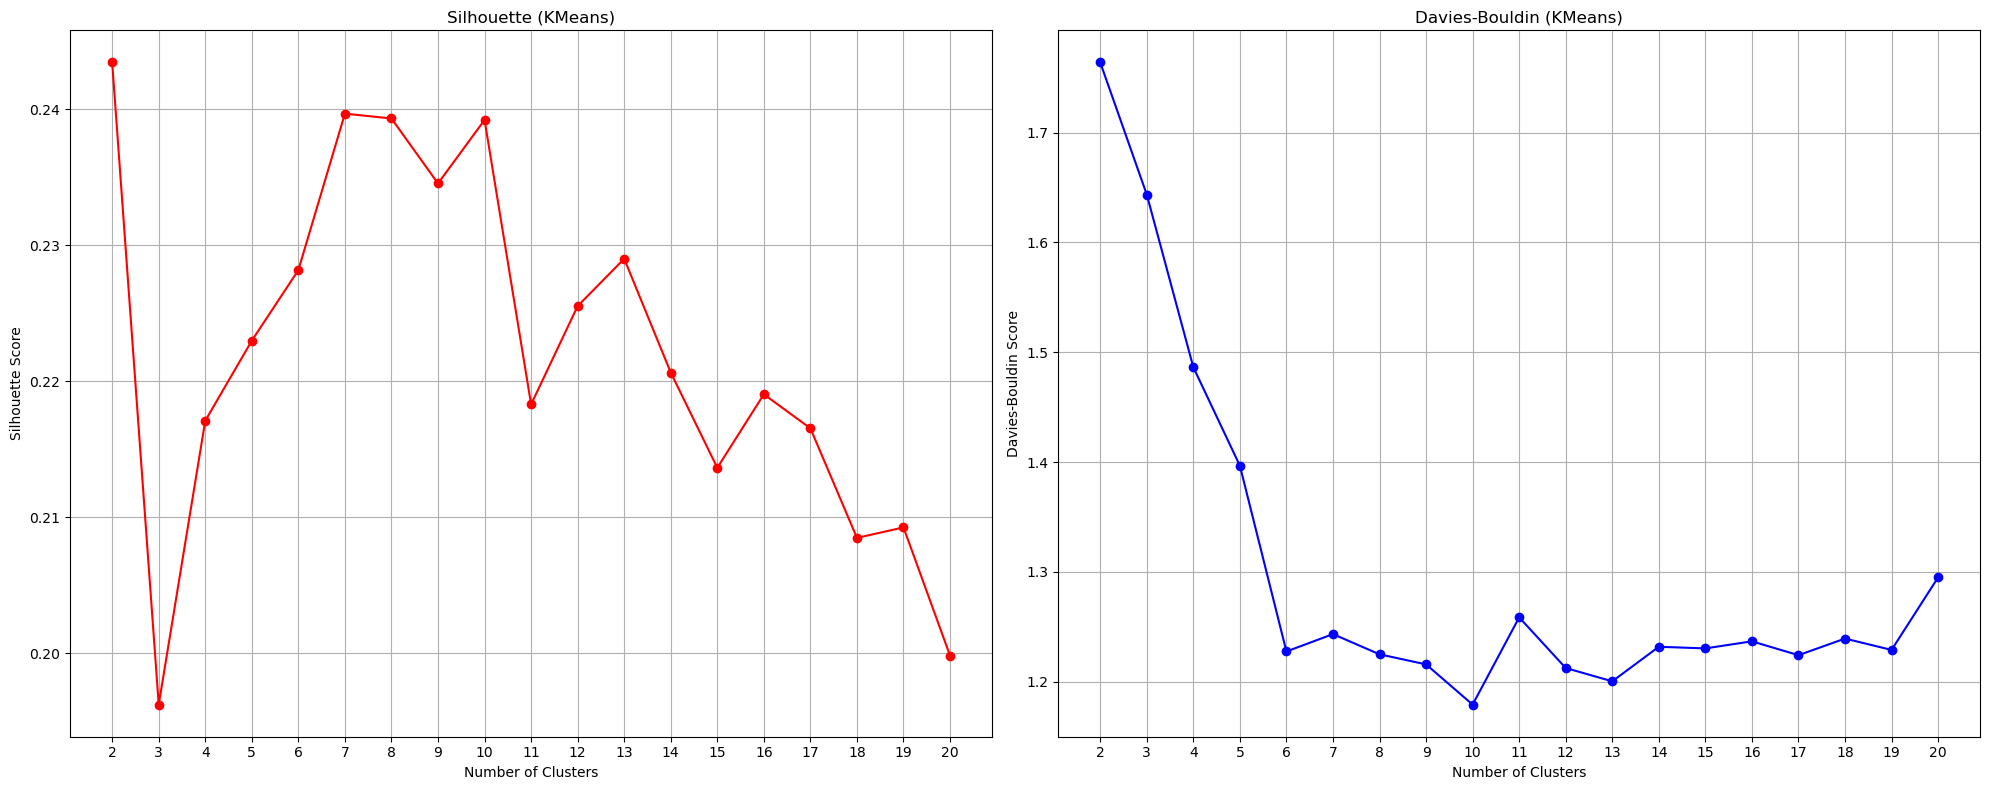

In [20]:
# Optional Visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Silhouette scores plot
plt.grid()
axes[0].plot(number_of_clusters, silhouette_list, marker="o", color="red")
axes[0].set_title("Silhouette (KMeans)")
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Silhouette Score")
axes[0].set_xticks(number_of_clusters)
axes[0].grid(True)


# Davies-Bouldin scores plot
plt.grid()
axes[1].plot(number_of_clusters, davies_bouldin_list, marker="o", color="blue")
axes[1].set_title("Davies-Bouldin (KMeans)")
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Davies-Bouldin Score")
axes[1].set_xticks(number_of_clusters)
axes[1].grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

Cluster labels: [1 1 1 ... 3 6 6]
Silhouette Score: 0.2392
Davies-Bouldin Score: 1.1792


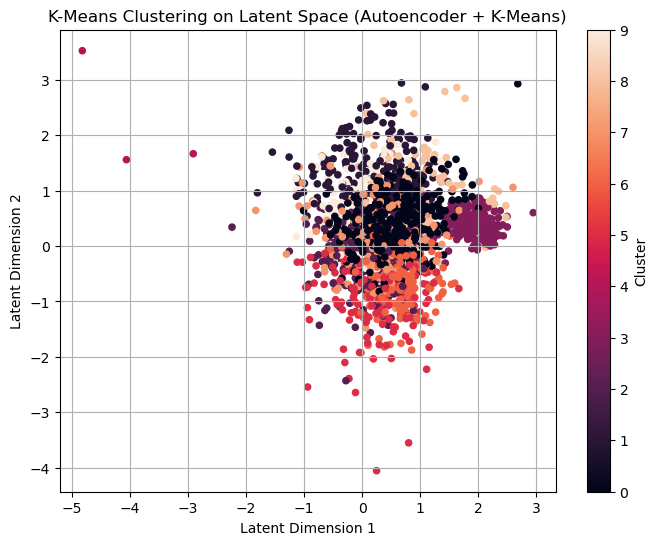

In [41]:

# Step 9: Apply K-Means to the latent space
num_clusters = 10  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters,  init='k-means++', n_init=10, random_state=42)
clusters_vect = kmeans.fit_predict(X_encoded)

# Step 10: Optionally, you can visualize the clusters or perform further evaluation
print("Cluster labels:", clusters_vect)

# Step 11: Evaluate clustering performance
silhouette_avg = silhouette_score(X_encoded, clusters_vect)
davies_bouldin = davies_bouldin_score(X_encoded, clusters_vect)
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")


# Optional Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_encoded[:, 2], X_encoded[:, 0], c=clusters_vect, cmap='rocket', s=20)
plt.title("K-Means Clustering on Latent Space (Autoencoder + K-Means)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

## Visualizing types

In [42]:
Covariates_trans_df = scaled_processed_transformed_df.copy()
Covariates_trans_df["type"] = clusters_vect
Covariates_trans_df.head()

,Population,Yes [nbr],No [nbr],0-19 years,20-64 years,65 years or older,Private households,Housing and infrastructure area (%),Total employment,Primary sector,...,mountain_type_Alpes (4),mountain_type_Forêt Noire - Jura Souabe (2),mountain_type_Jura (3),mountain_type_Moyen-pays - Rhin supérieur (1),mountain_type_pas de classification,language_french,language_german,language_italian,language_romansh,type
0,-0.116961,0.536053,-0.536053,-0.232315,0.648260,-0.304075,-0.108569,-0.108936,-0.125271,-0.320507,...,0,0,0,1,0,0,1,0,0,1
1,0.709513,0.801527,-0.801527,-0.112558,0.476857,-0.268631,0.638912,0.317648,0.348690,-0.812480,...,0,0,0,1,0,0,1,0,0,1
2,0.163071,1.071490,-1.071490,0.987378,-0.123958,-0.668564,0.133658,-0.035015,-0.083421,-0.650961,...,0,0,0,1,0,0,1,0,0,1
3,0.033404,0.620072,-0.620072,0.526105,-0.127512,-0.310426,0.006731,-0.081651,-0.082908,-0.303280,...,0,0,0,1,0,0,1,0,0,1
4,0.032567,0.649152,-0.649152,0.350015,0.469806,-0.619866,0.011316,-0.048645,-0.049472,-0.734983,...,0,0,0,1,0,0,1,0,0,1


In [43]:
typologies_df = Covariates_trans_df.groupby("type").mean()
typologies_df.mean()

Population                                                                2.026383
Yes [nbr]                                                                 0.247246
No [nbr]                                                                 -0.247246
0-19 years                                                               -0.187283
20-64 years                                                               0.093590
65 years or older                                                         0.074586
Private households                                                        2.046078
Housing and infrastructure area (%)                                       2.382718
Total employment                                                          2.078535
Primary sector                                                           -0.019964
Secondary sector                                                         -0.156038
Tertiary sector                                                           0.151682
New 

In [44]:
typologies_df_normalized = typologies_df.copy()

for col in typologies_df_normalized.columns:
    typologies_df_normalized[col] = (typologies_df_normalized[col]-typologies_df_normalized[col].mean())/typologies_df_normalized[col].std()

typologies_df_normalized

,Population,Yes [nbr],No [nbr],0-19 years,20-64 years,65 years or older,Private households,Housing and infrastructure area (%),Total employment,Primary sector,...,urban_typo_Urban municipality in a small or non-agglomerated area (13),mountain_type_Alpes (4),mountain_type_Forêt Noire - Jura Souabe (2),mountain_type_Jura (3),mountain_type_Moyen-pays - Rhin supérieur (1),mountain_type_pas de classification,language_french,language_german,language_italian,language_romansh
type,,,,,,,,,,,,,,,,,,,,,
0,-0.334890,0.878977,-0.878977,1.574376,-0.273688,-0.929579,-0.335170,-0.325289,-0.329077,0.530034,...,-0.731067,-1.162042,-0.577341,0.491412,1.453776,-0.927714,1.874294,-1.635078,-0.555103,-0.613723
1,-0.302863,-0.019424,0.019424,0.028640,-0.478068,0.354870,-0.304598,-0.314042,-0.317400,-0.524325,...,0.611484,-0.752436,-0.577341,-0.835984,1.057573,0.368823,-0.860633,1.128182,-0.555103,-0.613723
2,-0.310581,-0.661152,0.661152,0.314024,0.506450,-0.626309,-0.313003,-0.320214,-0.319591,-0.392042,...,1.288156,-0.545724,-0.290012,0.140802,0.443787,0.287584,-0.807897,1.063477,-0.527966,-0.613723
3,-0.353445,-0.244535,0.244535,0.313697,-0.075345,-0.168864,-0.350206,-0.331670,-0.337450,-0.942813,...,0.629834,0.227090,0.553586,-0.179264,-0.140674,-0.127774,0.103069,-0.171465,0.032360,1.121714
4,2.842661,2.021450,-2.021450,-1.234446,2.526384,-1.087864,2.843010,2.844808,2.844332,-1.099613,...,-1.026915,-1.423779,-0.577341,-1.213698,1.281742,2.249872,0.040029,0.218189,-0.555103,-0.613723
5,-0.324119,0.253775,-0.253775,1.199928,-0.124001,-0.774966,-0.324441,-0.326495,-0.324623,-0.036629,...,1.579858,0.194614,-0.577341,1.498978,-0.778984,-0.185915,1.660773,-1.458646,-0.461736,-0.613723
6,-0.342314,-0.852100,0.852100,-0.091407,-0.393606,0.375776,-0.340639,-0.330899,-0.332758,1.337752,...,-0.834269,0.603478,0.737690,1.654588,-0.978467,-1.060730,-0.188504,0.331461,-0.461953,1.404226
7,-0.185339,0.563119,-0.563119,-0.378829,-0.045471,0.311163,-0.191373,-0.234079,-0.219346,-0.912931,...,0.309173,0.865638,-0.577341,-0.957015,-0.427497,-0.290452,-0.259025,-0.676179,2.287461,-0.613723
8,-0.345254,-0.398106,0.398106,-1.789934,-1.336223,2.351460,-0.341831,-0.331189,-0.331113,0.158286,...,-0.799339,1.882367,-0.577341,-0.776490,-1.364933,-1.036928,-0.764786,0.135845,1.352245,1.770118


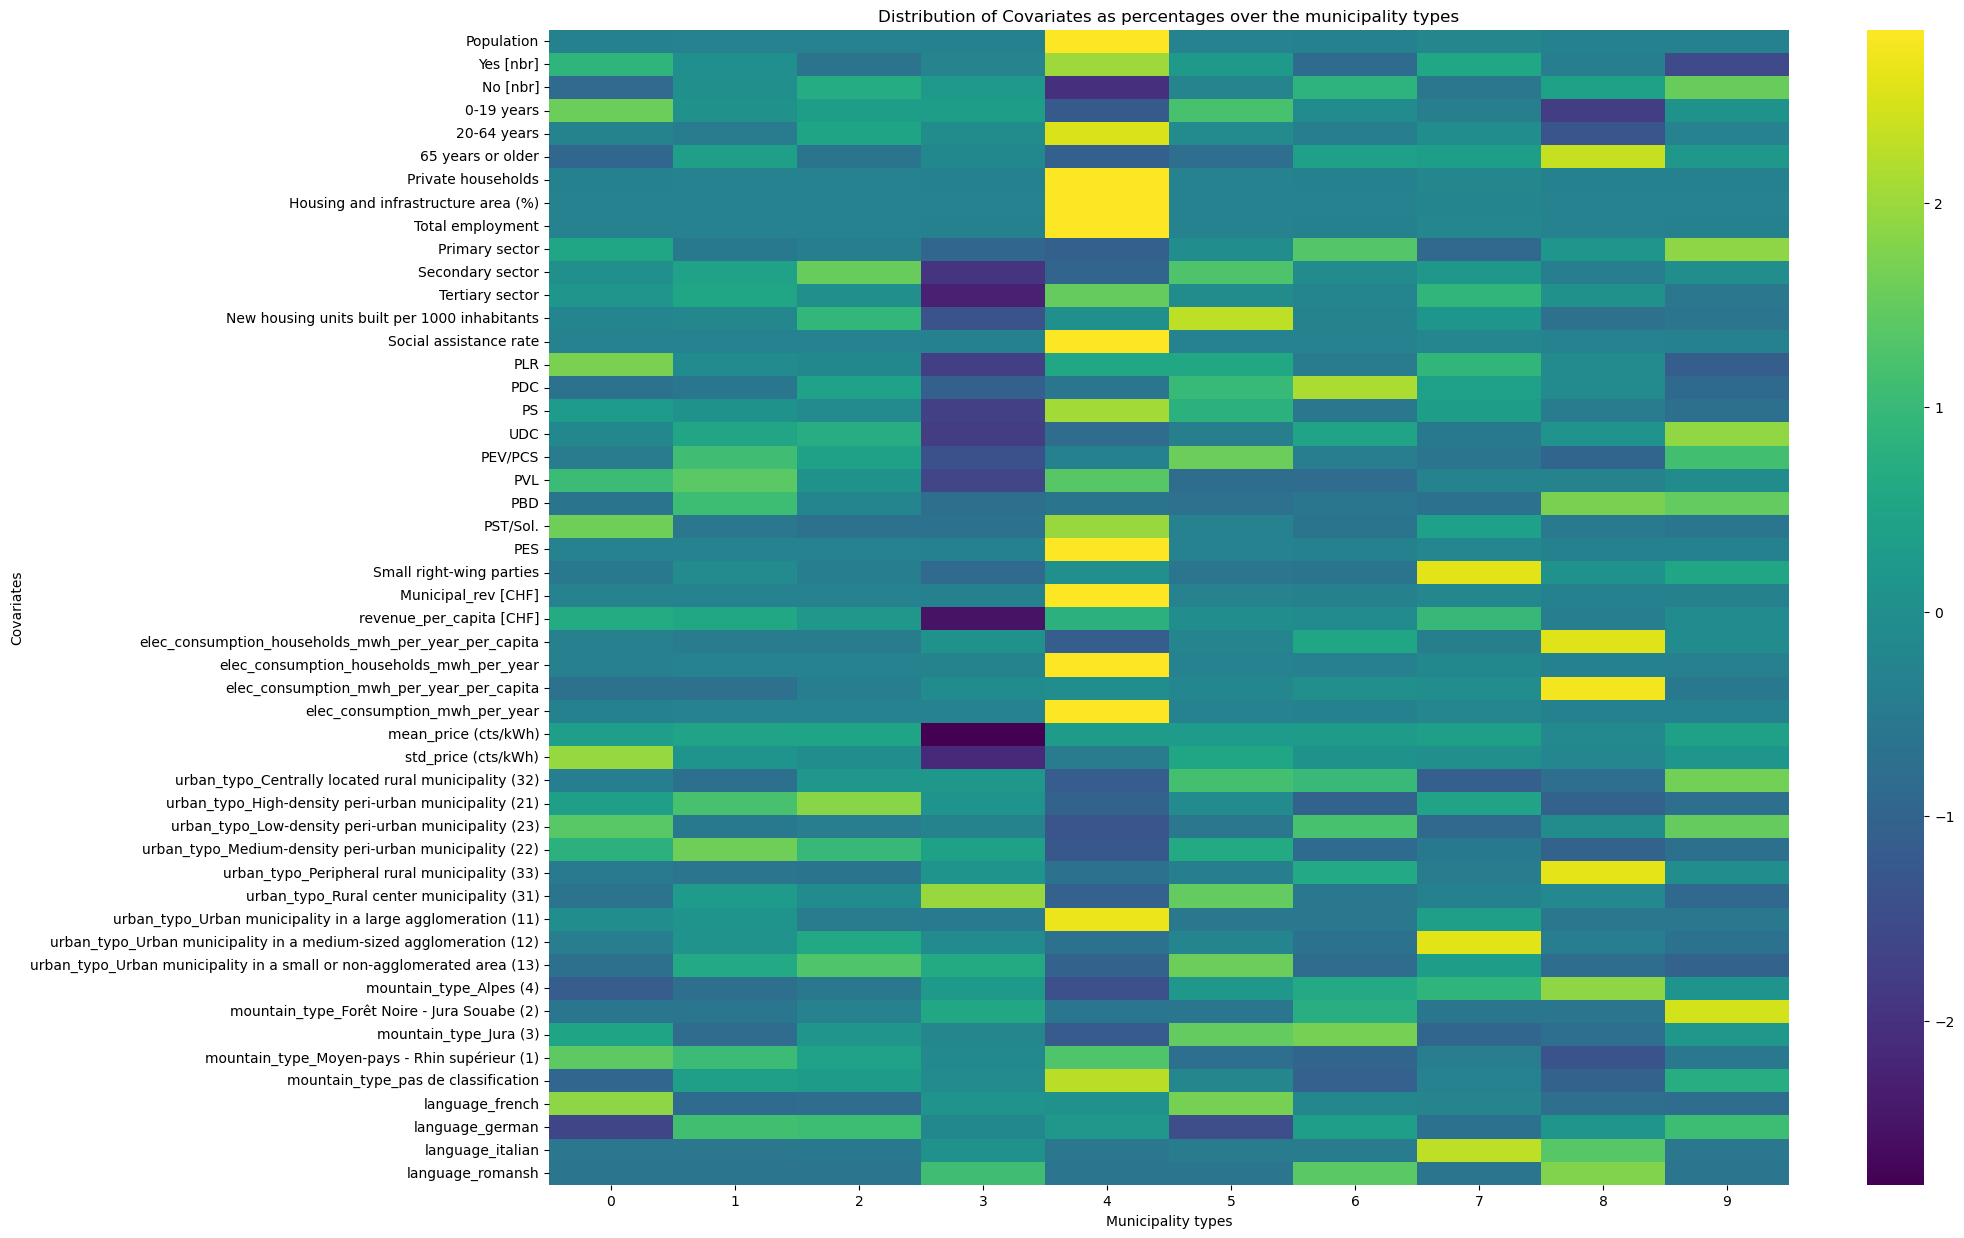

In [45]:
# Create a heatmap of the DataFrame
plt.figure(figsize=(20, 15))
sns.heatmap(typologies_df_normalized.T, annot=False, fmt='g', cmap='viridis', cbar=True)

# Add labels and title
plt.title("Distribution of Covariates as percentages over the municipality types")
plt.xlabel("Municipality types")
plt.ylabel("Covariates")
plt.show()

In [46]:
Covariates_trans_df

,Population,Yes [nbr],No [nbr],0-19 years,20-64 years,65 years or older,Private households,Housing and infrastructure area (%),Total employment,Primary sector,...,mountain_type_Alpes (4),mountain_type_Forêt Noire - Jura Souabe (2),mountain_type_Jura (3),mountain_type_Moyen-pays - Rhin supérieur (1),mountain_type_pas de classification,language_french,language_german,language_italian,language_romansh,type
0,-0.116961,0.536053,-5.360534e-01,-0.232315,0.648260,-3.040746e-01,-0.108569,-0.108936,-0.125271,-0.320507,...,0,0,0,1,0,0,1,0,0,1
1,0.709513,0.801527,-8.015272e-01,-0.112558,0.476857,-2.686305e-01,0.638912,0.317648,0.348690,-0.812480,...,0,0,0,1,0,0,1,0,0,1
2,0.163071,1.071490,-1.071490e+00,0.987378,-0.123958,-6.685636e-01,0.133658,-0.035015,-0.083421,-0.650961,...,0,0,0,1,0,0,1,0,0,1
3,0.033404,0.620072,-6.200724e-01,0.526105,-0.127512,-3.104258e-01,0.006731,-0.081651,-0.082908,-0.303280,...,0,0,0,1,0,0,1,0,0,1
4,0.032567,0.649152,-6.491516e-01,0.350015,0.469806,-6.198665e-01,0.011316,-0.048645,-0.049472,-0.734983,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,-0.269000,0.000000,5.033877e-16,0.000000,0.000000,-6.779984e-16,-0.247452,-0.139298,-0.157610,-0.853508,...,0,0,1,0,0,1,0,0,0,3
2127,-0.269000,0.000000,5.033877e-16,0.000000,0.000000,-6.779984e-16,-0.247452,-0.139298,-0.157610,-0.853508,...,0,0,1,0,0,1,0,0,0,3
2128,-0.269000,0.000000,5.033877e-16,0.000000,0.000000,-6.779984e-16,-0.247452,-0.139298,-0.157610,-0.853508,...,0,0,1,0,0,1,0,0,0,3
2129,-0.269000,0.000000,5.033877e-16,-0.182675,-2.212650,1.789749e+00,-0.221411,-0.136854,-0.153878,1.715516,...,0,0,0,0,1,1,0,0,0,6


## Importing PV data

In [47]:
Swiss_solar_potential = pd.read_csv("../../data/cleaned_data/Swiss_solar_potential.csv")

In [48]:
Swiss_solar_potential["type"]=clusters_vect
Swiss_solar_potential.sample()

,mun_name,canton_abr,pv_pot,pv_pot_reco,fpv_pot,fpv_pot_reco,roof_area,facade_area,total_power,total_energy,...,Scenario3_RoofsFacades_PotentialSolarElectricity_Month09_GWh,Scenario3_RoofsFacades_PotentialSolarElectricity_Month10_GWh,Scenario3_RoofsFacades_PotentialSolarElectricity_Month11_GWh,Scenario3_RoofsFacades_PotentialSolarElectricity_Month12_GWh,Scenario4_RoofsFacades_PotentialSolarElectricity_GWh,Scenario4_RoofsFacades_PotentialSolarHeat_GWh,Factsheet,Methodology,mun_id,type
1598,Rüdlingen,SH,8.187682e+06,5.930263e+06,3.655006e+06,2.040371e+06,78195.468092,80465.14503,418.94,418940.0,...,1.01,0.62,0.34,0.26,7.93,2.11,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,2938,5


In [49]:
Swiss_solar_potential.columns

Index(['mun_name', 'canton_abr', 'pv_pot', 'pv_pot_reco', 'fpv_pot',
       'fpv_pot_reco', 'roof_area', 'facade_area', 'total_power',
       'total_energy', 'initial_power', 'total_potential',
       'recommended_potential', 'achieved_rp', 'achieved_tp', 'Canton',
       'Country', 'Scenario1_RoofsOnly_PotentialSolarElectricity_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month01_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month02_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month03_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month04_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month05_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month06_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month07_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month08_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month09_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectrici

In [50]:
Swiss_solar_potential["achieved_rp"].median()

0.0745356492374057

In [51]:
pv_typologies_df = Swiss_solar_potential.groupby("type")["achieved_rp"].agg(["median", "mean", "std"])
pv_typologies_df

,median,mean,std
type,,,
0,0.044098,0.041972,0.015166
1,0.126465,0.137802,0.078261
2,0.078472,0.087228,0.041039
3,0.072038,0.075255,0.036262
4,0.082195,0.085280,0.070433
5,0.050724,0.056919,0.035770
6,0.077053,0.067558,0.031855
7,0.055915,0.068981,0.042399
8,0.070884,0.075600,0.025755


In [52]:
Swiss_solar_potential[Swiss_solar_potential.type==6]["achieved_rp"]

242     0.137985
251     0.136369
350     0.120185
352     0.119933
355     0.119579
          ...   
2114    0.002333
2120    0.000000
2122    0.000000
2129    0.000000
2130    0.000000
Name: achieved_rp, Length: 215, dtype: float64

In [53]:
Swiss_solar_potential["type"].value_counts()

type
2    492
1    316
0    280
3    250
6    215
9    186
7    155
5    143
8     91
4      3
Name: count, dtype: int64

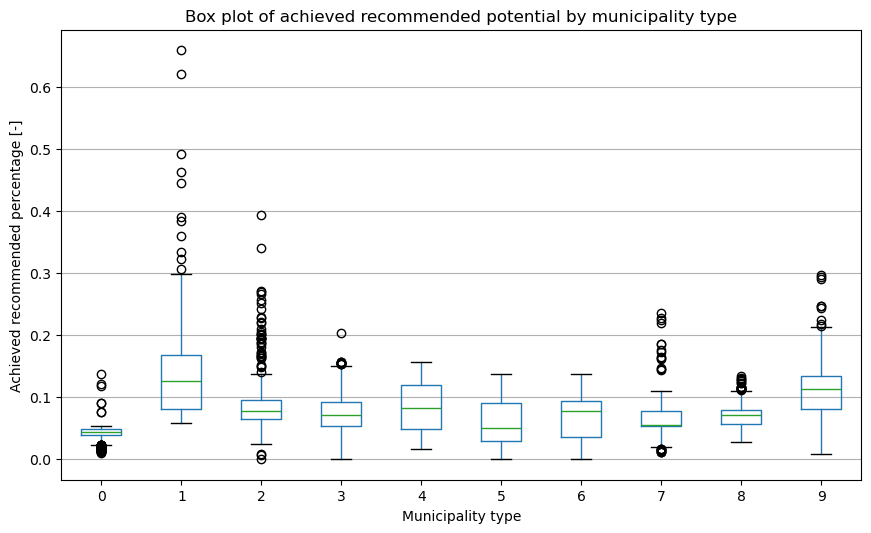

In [54]:
Swiss_solar_potential.boxplot(column="achieved_rp", by="type", grid=False, figsize=(10, 6))

plt.title("Box plot of achieved recommended potential by municipality type")
plt.suptitle("")  # Removes the automatic subtitle added by pandas
plt.xlabel("Municipality type")
plt.ylabel("Achieved recommended percentage [-]")
plt.grid(axis="y")
plt.show()

In [55]:

# Get the top 10 largest values for each category
top_10_per_category = Swiss_solar_potential.groupby("type")[["type", "achieved_rp"]].apply(lambda x: x.nlargest(10, 'achieved_rp')).reset_index(drop=True)

print("\nTop 10 largest values for each category:")
print(top_10_per_category)



Top 10 largest values for each category:
    type  achieved_rp
0      0     0.137663
1      0     0.121448
2      0     0.118654
3      0     0.090578
4      0     0.090008
..   ...          ...
88     9     0.243859
89     9     0.225069
90     9     0.218004
91     9     0.215266
92     9     0.213104

[93 rows x 2 columns]


In [56]:
average_std_top_10 = top_10_per_category.groupby("type")["achieved_rp"].agg(["mean", "std"]).reset_index()
average_std_top_10

,type,mean,std
0,0,0.086871,0.030798
1,1,0.446843,0.115681
2,2,0.274653,0.052457
3,3,0.160173,0.015357
4,4,0.085280,0.070433
5,5,0.119140,0.014764
6,6,0.120229,0.010675
7,7,0.195373,0.028105
8,8,0.124498,0.006135
9,9,0.248924,0.033200


<Axes: xlabel='type'>

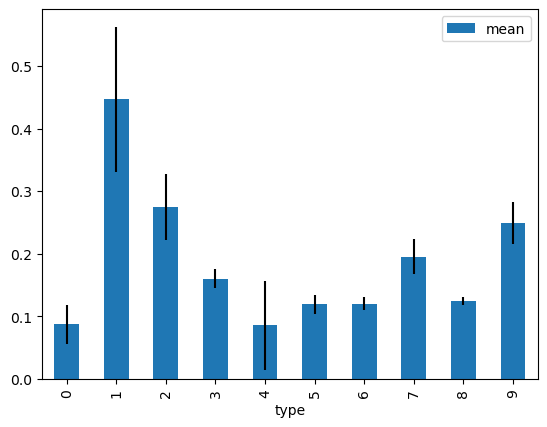

In [57]:
average_std_top_10.plot(kind="bar", x="type", y="mean", yerr="std")

In [58]:

# Get the top 10 smallest values for each category
low_10_per_category = Swiss_solar_potential.groupby("type")[["type", "achieved_rp"]].apply(lambda x: x.nsmallest(10, 'achieved_rp')).reset_index(drop=True)

print("\nTop 10 smallest values for each category:")
print(low_10_per_category)



Top 10 smallest values for each category:
    type  achieved_rp
0      0     0.010882
1      0     0.011775
2      0     0.011942
3      0     0.012219
4      0     0.012457
..   ...          ...
88     9     0.058413
89     9     0.059000
90     9     0.059165
91     9     0.059262
92     9     0.059627

[93 rows x 2 columns]


In [59]:
average_std_low_10 = low_10_per_category.groupby("type")["achieved_rp"].agg(["mean", "std"]).reset_index()
average_std_low_10

,type,mean,std
0,0,0.012639,0.001003
1,1,0.059418,0.000891
2,2,0.021619,0.012240
3,3,0.002692,0.003088
4,4,0.085280,0.070433
5,5,0.002153,0.001981
6,6,0.002283,0.002412
7,7,0.014662,0.002521
8,8,0.036495,0.008362
9,9,0.051572,0.016549


<Axes: xlabel='type'>

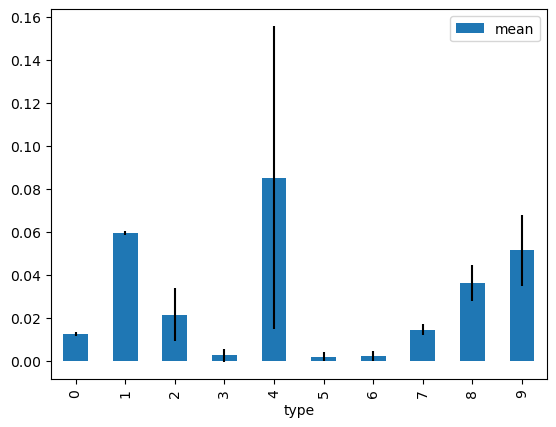

In [60]:
average_std_low_10.plot(kind="bar", x="type", y="mean", yerr="std")